In [1]:
%load_ext autoreload
%autoreload 2

# Core imports
from causalab.tasks.MCQA.causal_models import positional_causal_model
from causalab.tasks.MCQA.counterfactuals import (
    different_symbol,
    same_symbol_different_position,
    random_counterfactual,
)
from causalab.tasks.MCQA.token_positions import create_token_positions

# Neural framework imports
from causalab.neural.pipeline import LMPipeline
from causalab.neural.token_position_builder import get_all_tokens

# Causal and filtering imports
from causalab.causal.counterfactual_dataset import CounterfactualDataset
from causalab.experiments.filter import filter_dataset

# Standard imports
import torch
import os

# Setup
causal_model = positional_causal_model

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
pipeline = LMPipeline(
    model_name,
    max_new_tokens=1,
    device=device,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    max_length=32,
)
pipeline.tokenizer.padding_side = "left"


def checker(neural_output, causal_output):
    return (
        causal_output in neural_output["string"]
        or neural_output["string"] in causal_output
    )


size = 64

# Set up counterfactual generators
counterfactual_generators = {
    "different_symbol": different_symbol,
    "same_symbol_different_position": same_symbol_different_position,
    "random_counterfactual": random_counterfactual,
}

# Generate and filter training datasets
print("Generating training datasets...")
counterfactual_datasets = {}
for name, sampler in counterfactual_generators.items():
    counterfactual_datasets[name] = CounterfactualDataset.from_sampler(size, sampler)

print("\nFiltering training datasets...")
filtered_datasets = {}
for name, dataset in counterfactual_datasets.items():
    filtered_datasets[name] = filter_dataset(
        dataset=dataset,
        pipeline=pipeline,
        causal_model=causal_model,
        metric=checker,
        batch_size=128,
    )

print(f"\n✓ Generated and filtered {len(filtered_datasets)} training datasets")

# Generate and filter test datasets
print("\nGenerating test datasets...")
test_counterfactual_datasets = {}
for name, sampler in counterfactual_generators.items():
    test_counterfactual_datasets[name] = CounterfactualDataset.from_sampler(size, sampler)

print("\nFiltering test datasets...")
test_filtered_datasets = {}
for name, dataset in test_counterfactual_datasets.items():
    test_filtered_datasets[name] = filter_dataset(
        dataset=dataset,
        pipeline=pipeline,
        causal_model=causal_model,
        metric=checker,
        batch_size=128,
    )

print(f"\n✓ Generated and filtered {len(test_filtered_datasets)} test datasets")

# Save datasets to disk for use by training scripts
train_datasets_dir = "./temp_train_datasets"
test_datasets_dir = "./temp_test_datasets"

for name, dataset in filtered_datasets.items():
    dataset_path = os.path.join(train_datasets_dir, name, "filtered_dataset")
    os.makedirs(dataset_path, exist_ok=True)
    dataset.dataset.save_to_disk(dataset_path)
    print(f"✓ Saved training dataset: {dataset_path}")

for name, dataset in test_filtered_datasets.items():
    dataset_path = os.path.join(test_datasets_dir, name, "filtered_dataset")
    os.makedirs(dataset_path, exist_ok=True)
    dataset.dataset.save_to_disk(dataset_path)
    print(f"✓ Saved test dataset: {dataset_path}")

# Create token positions
token_positions = create_token_positions(pipeline)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generating training datasets...

Filtering training datasets...

✓ Generated and filtered 3 training datasets

Generating test datasets...

Filtering test datasets...

✓ Generated and filtered 3 test datasets


Saving the dataset (0/1 shards):   0%|          | 0/61 [00:00<?, ? examples/s]

✓ Saved training dataset: ./temp_train_datasets/different_symbol/filtered_dataset


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

✓ Saved training dataset: ./temp_train_datasets/same_symbol_different_position/filtered_dataset


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

✓ Saved training dataset: ./temp_train_datasets/random_counterfactual/filtered_dataset


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

✓ Saved test dataset: ./temp_test_datasets/different_symbol/filtered_dataset


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

✓ Saved test dataset: ./temp_test_datasets/same_symbol_different_position/filtered_dataset


Saving the dataset (0/1 shards):   0%|          | 0/57 [00:00<?, ? examples/s]

✓ Saved test dataset: ./temp_test_datasets/random_counterfactual/filtered_dataset


# Supervised Causal Variable Localization 

In the third notebook, we performed interchange interventions on the residual stream of a language model and then used our hypothesized causal model to interpret the results and localize the causal variables. While these experiments were revealing, intervening on the entire residual stream vector is a crude operation that lacks the surgical precision needed for a fine-grained analysis. A core capability of this code base is training loops that are set up to **use the hypothesized causal model as a source of supervision** for deciding where to perform interventions. 

First, we will show how Distributed Alignment Search (DAS) can be used to learn a linear subspace of the residual stream that contains a causal variable. Second, we will use Desiderata-Based Masking to localize the attention heads that carry over the answer position variable and the answer itself.

## Learning Linear Features with Distributed Alignment Search (DAS)

Our interchange intervention experiments in the third notebook indicated that the residual stream of the last token at layer 15 approximately contains the answer position variable. However, full vector patching is a crude instrument. A more surgical approach would be to intervene upon **features** of the resisual stream instead. We will learn a set of orthogonal linear features that form a subspace of the residual stream.  

In [2]:
from IPython.display import display, Image

# Check that image exists


if os.path.exists("vector_patching_results/heatmap_dataset_same_symbol_different_position_MCQA_vector_patching_variables_answer_position.png"):
    display(
        Image(
            filename="vector_patching_results/heatmap_dataset_same_symbol_different_position_MCQA_vector_patching_variables_answer_position.png"
        )
    )



For each token position and model layer we train a set of 16 orthogonal linear features to realize the answer_position variable in the causal model. 
We again perform interchange interventions on the causal model and the language model, but we will now use the output of the causal model under intervention as a source of supervision to learn where to intervene in the language model. 
Instead of intervening on the full residual stream vector of the language model, we intervene on a linear subspace that is parameterized using 16 orthogonal vectors. 
Then we update these orthogonal vectors such that the output of the LM under interchange intervention is the same as the output of the causal model wtih an interchange intervention on the answer position variable.

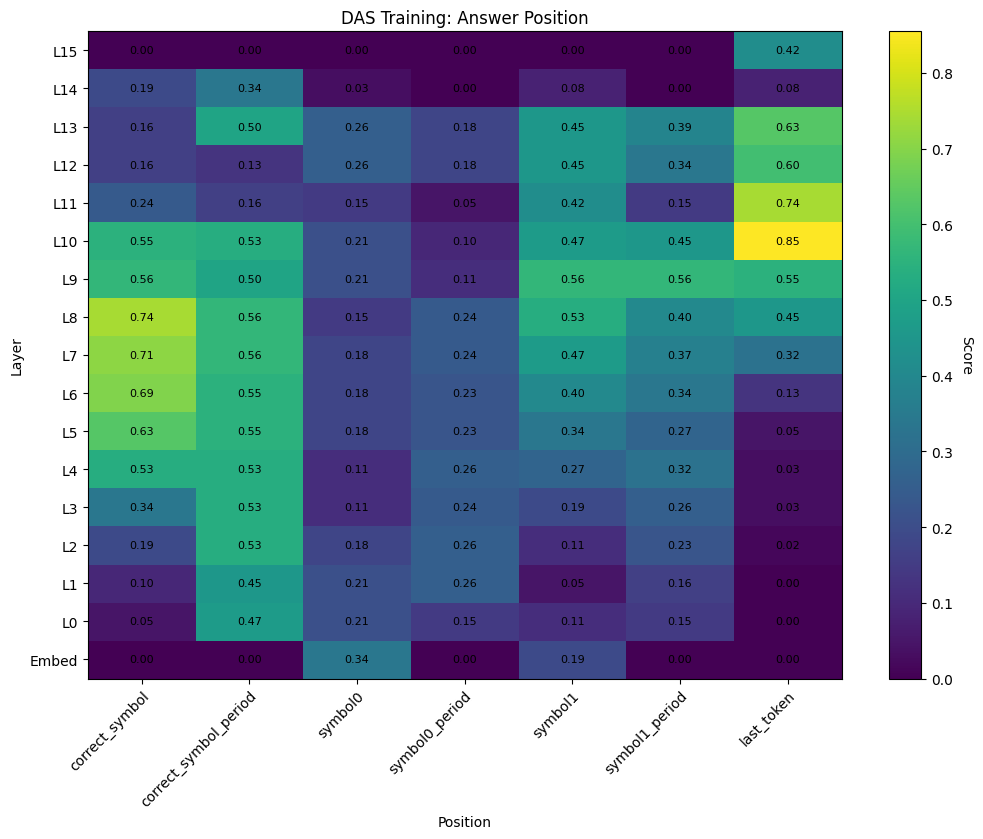

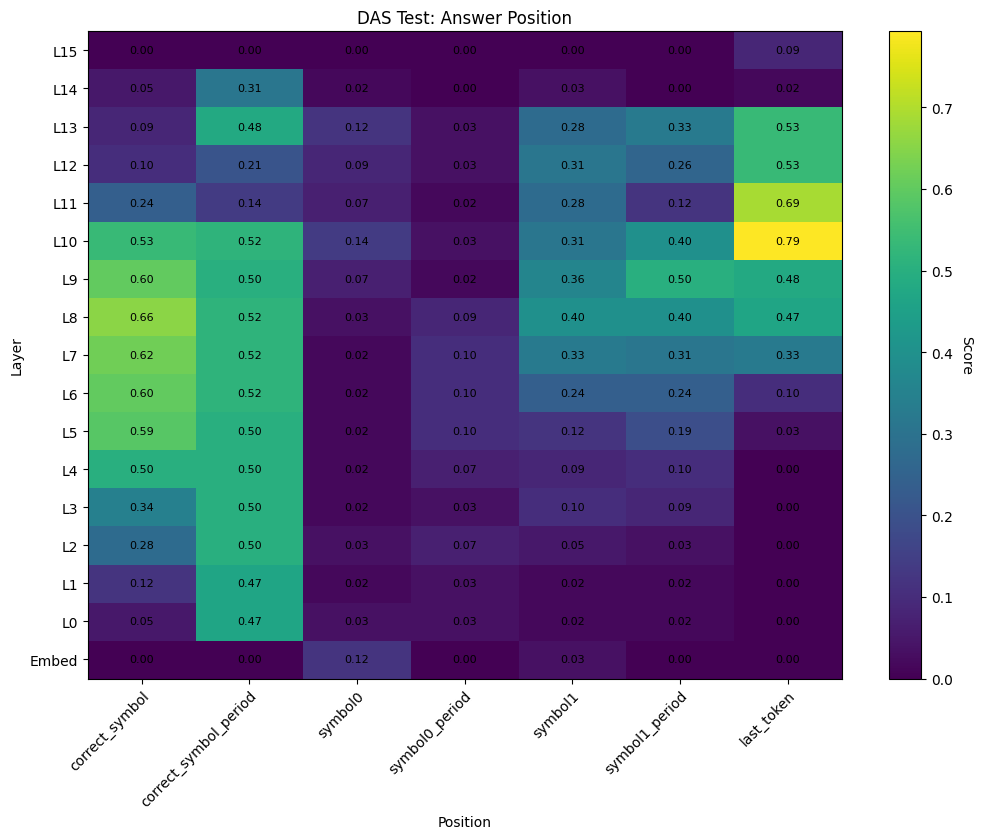


✓ Best training score: 0.855
✓ Best test score: 0.793


In [3]:
# Train DAS using the residual_stream_DAS script
from causalab.experiments.jobs.DAS_grid import train_DAS 
from causalab.experiments.interchange_targets import build_residual_stream_targets
from causalab.tasks.MCQA.token_positions import create_token_positions

all_token_positions = create_token_positions(pipeline)

# Define which token positions to use
ordered_position_names = [
    "correct_symbol",
    "correct_symbol_period",
    "symbol0",
    "symbol0_period",
    "symbol1",
    "symbol1_period",
    "last_token"
]

token_positions = [all_token_positions[name] for name in ordered_position_names]

# Get dataset paths (from the generate_dataset calls above)
train_dataset_path = "./temp_train_datasets/same_symbol_different_position/filtered_dataset"
test_dataset_path = "./temp_test_datasets/same_symbol_different_position/filtered_dataset"


# Define layers to analyze
num_layers = pipeline.model.config.num_hidden_layers
layers = [-1] + list(range(num_layers))

targets = build_residual_stream_targets(
    pipeline=pipeline,
    layers=layers,
    token_positions=token_positions,
    mode="one_target_per_unit",
)

# Train DAS and get results
das_result = train_DAS(
    interchange_targets=targets,
    causal_model=causal_model,
    train_dataset_path=train_dataset_path,
    test_dataset_path=test_dataset_path,
    pipeline=pipeline,
    target_variable_group=("answer_position",),
    output_dir="./DAS_results",
    metric=checker,
    verbose=True,
)

# Extract results for later use
train_results = das_result["train_scores"]
test_results = das_result["test_scores"]

print(f"\n✓ Best training score: {das_result['metadata']['train_max_score']:.3f}")
print(f"✓ Best test score: {das_result['metadata']['test_max_score']:.3f}")

## Held-Out Test Set Evaluation

DAS uses stoichastic gradient descent to search for a linear representation that satisfies causal properties expressed in the form of causal models and counterfactual datasets used for activation patching. Crucially, this puts us into a typical machine learning setting where **generalization** of the learned solution is essential. Causal variables found by DAS can be **overfit** to the training data, and provide a weaker signal when evaluated on held-out test data.

Observe below how the heatmap for test data shows weaker results than the train data heatmap, and these examples are generated in the exact same way.

## Evaluation Results

The training and test results show how well the learned DAS subspace generalizes to held-out data. The scores indicate how well the intervention on the learned subspace recovers the causal variable.

## Three Stages of Retrieval

The test results show three stages of retrieval with positional information. The causal variable is best localized at layer 15, with a weaker signal for the next four layers and then an even weaker signal for two layers. We can only see the first two stages in the full vector patching results!

The training results are spiky and more difficult to interpret, in contrast to the smooth gradation in the test results. This is clearly due to overfitting on a small dataset, which can be improved upon with more data.

We can see these three stages in the full vector patching results with the different symbol counterfactuals evaluated on the answer variable:

In [4]:
from IPython.display import display, Image

# Check if image exists
if os.path.exists("vector_patching_results/heatmap_dataset_same_symbol_different_position_MCQA_vector_patching_variables_answer.png"):
    display(
        Image(
            filename="vector_patching_results/heatmap_dataset_same_symbol_different_position_MCQA_vector_patching_variables_answer.png"
        )
    )

## Finding the Attention Heads that Bring in the Answer

Logically, there must be attention heads that are responsible for this movement. We will now train binary masks over attention head outputs that select which head outputs are targeted for interchange intervention, using the answer variable as a signal. This is called Desiderata-Based Masking (DBM). During training, the masks are continuous valued and a temperature term is annealed to make them converge to binary values. During testing, binary values are used. 

We train the masks to identify the heads that bring over the answer, then we print the accuracy on test data and the value of the binary masks. The selected attention heads generalize perfectly to the held-out test data (though this is still only for a single prompt template). 

Observe that the attention heads that bring over the answer variable correspond to exactly the three stages of computation we identified with our residual patching results. 

In [5]:
# Import DBM script and target builders
from causalab.experiments.jobs.DBM_binary_grid import train_DBM_binary_heatmaps
from causalab.experiments.interchange_targets import build_attention_head_targets

# Create token position that targets all tokens
# get_all_tokens already returns a TokenPosition, so we use it directly
sample_input = filtered_datasets["different_symbol"][0]["input"]
all_tokens = get_all_tokens(sample_input, pipeline, padding=True)

# Get model configuration
num_layers = pipeline.model.config.num_hidden_layers
num_heads = pipeline.model.config.num_attention_heads

print(f"Model has {num_layers} layers and {num_heads} attention heads per layer")

# Build attention head targets for all layers and heads
attention_targets = build_attention_head_targets(
    pipeline=pipeline,
    layers=list(range(num_layers)),
    heads=list(range(num_heads)),
    token_position=all_tokens,
    mode="one_target_all_units",  # Single target with all heads for DBM
)

print(f"Built attention head target with {len(attention_targets[('all',)])} units")

Model has 16 layers and 32 attention heads per layer
Built attention head target with 1 units


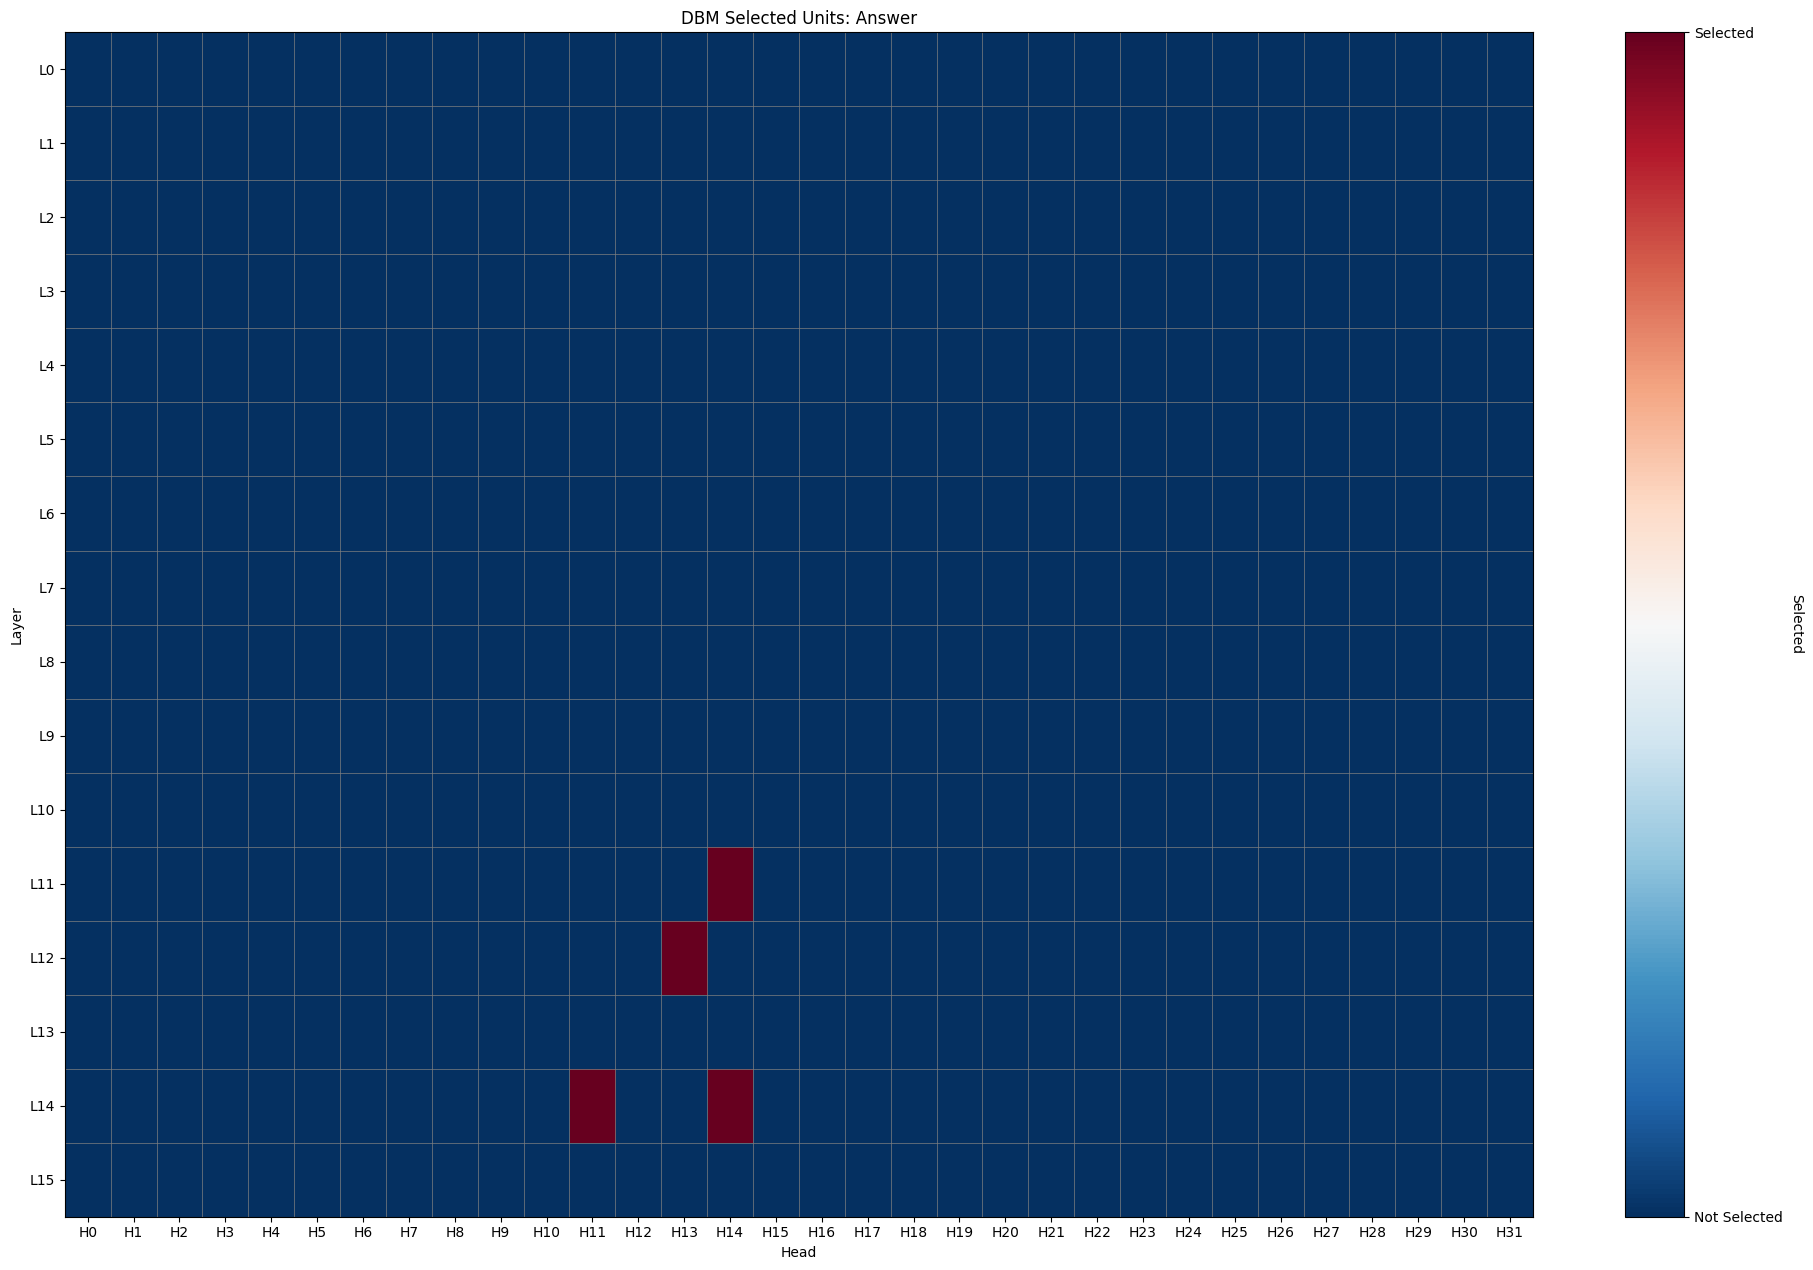

In [6]:
# Run DBM to find attention heads carrying the answer variable
# The function auto-detects component type from the target and generates appropriate visualizations
dbm_result = train_DBM_binary_heatmaps(
    causal_model=causal_model,
    interchange_target=attention_targets[("all",)],  # Pre-built target
    train_dataset_path="./temp_train_datasets/different_symbol/filtered_dataset",
    test_dataset_path="./temp_test_datasets/different_symbol/filtered_dataset",
    pipeline=pipeline,
    target_variable_group=("answer",),
    output_dir="./DBM_attention_results",
    metric=checker,
    tie_masks=True,
    verbose=True,
)

In [7]:
# Print summary
print("=" * 80)
print("DBM RESULTS SUMMARY")
print("=" * 80)
print(f"Component Type: {dbm_result['component_type']}")
print(f"Train Accuracy: {dbm_result['train_score']:.3f}")
print(f"Test Accuracy: {dbm_result['test_score']:.3f}")
print(f"Selected Units: {dbm_result['metadata']['num_selected_units']} out of {dbm_result['metadata']['num_units']}")
print("\nSelected (layer, head) pairs:")
for layer, head in dbm_result['selected_units']:
    print(f"  Layer {layer:2d}, Head {head:2d}")

DBM RESULTS SUMMARY
Component Type: attention_head
Train Accuracy: 0.967
Test Accuracy: 0.966
Selected Units: 4 out of 512

Selected (layer, head) pairs:
  Layer 11, Head 14
  Layer 12, Head 13
  Layer 14, Head 11
  Layer 14, Head 14


# Takeaways

This notebook demonstrates the core capabilities of this code base and the results demonstrate how residual stream and attention head analysis have productive interplay.

Supervised machine learning methods are powerful, and mechanistic interpretability will be all the better for embracing them! We can leverage our hypothesized causal model to find model representations that play crucial roles in algorithms underlying language model behavior. However, we must be careful. Now that we have methods that use greadient descent to search for evidence of a hypothesis, it is easy to overfit our analysis to the small slice of data used for training. We must be careful to use train-test splits to evaluate whether causal variables are being robustly localized.

## Finding the MLPs that Process the Answer

Attention heads select and route information between positions, but MLPs transform the representations at each position. We can use DBM to identify which MLP layers are critical for processing the answer variable.

Similar to our attention head analysis, we train binary masks over MLP outputs to select which layers contribute to the answer variable computation.

In [8]:
# Import MLP target builder
from causalab.experiments.interchange_targets import build_mlp_targets

ordered_position_names = [
    "correct_symbol",
    "correct_symbol_period",
    "last_token"
]

token_positions = [all_token_positions[name] for name in ordered_position_names]

# Build MLP targets for all layers
# Using mlp_output to see which MLPs contribute to the final answer
mlp_targets = build_mlp_targets(
    pipeline=pipeline,
    layers=list(range(num_layers)),
    token_positions=token_positions,  # Note: list for MLPs (different from attention heads)
    mode="one_target_all_units",
    location="mlp_output",
)

print(f"Built MLP target with {len(mlp_targets[('all',)].flatten())} units")

Built MLP target with 48 units


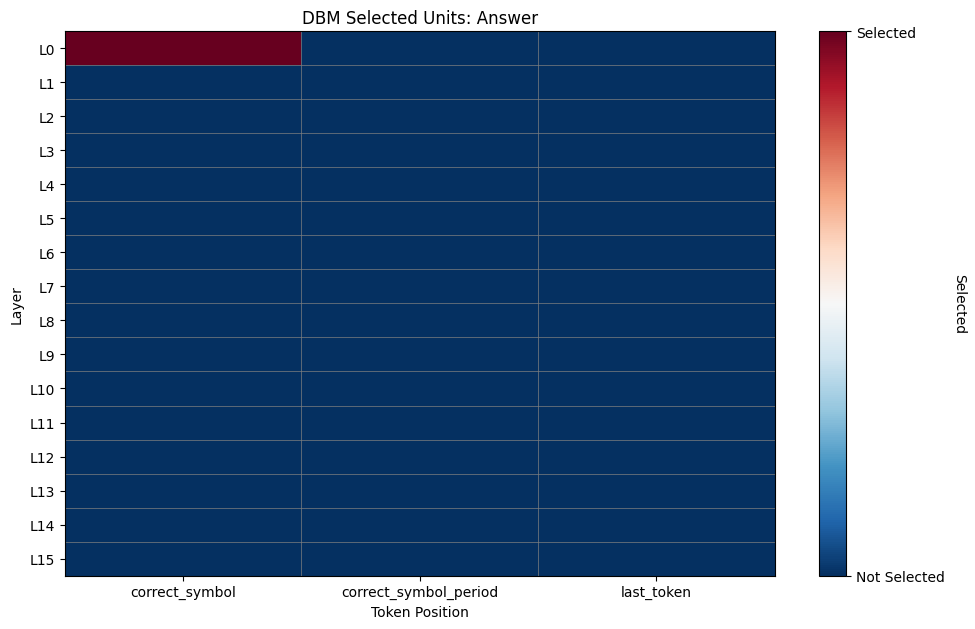

In [9]:
# Run DBM to find MLPs contributing to the answer variable
mlp_dbm_result = train_DBM_binary_heatmaps(
    causal_model=causal_model,
    interchange_target=mlp_targets[("all",)],
    train_dataset_path="./temp_train_datasets/different_symbol/filtered_dataset",
    test_dataset_path="./temp_test_datasets/different_symbol/filtered_dataset",
    pipeline=pipeline,
    target_variable_group=("answer",),
    output_dir="./DBM_mlp_results",
    metric=checker,
    tie_masks=True,
    verbose=True,
)

In [10]:
# Print MLP DBM summary
print("=" * 80)
print("MLP DBM RESULTS SUMMARY")
print("=" * 80)
print(f"Component Type: {mlp_dbm_result['component_type']}")
print(f"Train Accuracy: {mlp_dbm_result['train_score']:.3f}")
print(f"Test Accuracy: {mlp_dbm_result['test_score']:.3f}")
print(f"Selected Units: {mlp_dbm_result['metadata']['num_selected_units']} out of {mlp_dbm_result['metadata']['num_units']}")
print("\nSelected (layer, token_position) pairs:")
for layer, token_pos in mlp_dbm_result['selected_units']:
    print(f"  Layer {layer:2d}, Position: {token_pos}")

MLP DBM RESULTS SUMMARY
Component Type: mlp
Train Accuracy: 0.951
Test Accuracy: 0.983
Selected Units: 1 out of 48

Selected (layer, token_position) pairs:
  Layer  0, Position: correct_symbol


## Comparing Attention Heads and MLPs

The DBM results for attention heads and MLPs provide complementary views of the computation:

- **Attention heads** select and route information between token positions. The heads identified above are responsible for *moving* the answer from its source position to the final token.

- **MLPs** transform representations at each position. The MLPs identified above are responsible for *processing* the answer information once it arrives.

Together, these analyses reveal the division of labor in the transformer: attention heads handle information routing while MLPs handle information processing. By applying DBM to both component types, we get a more complete picture of how the model implements the MCQA task.